In [10]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis

from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [2]:
gz = 0
anti = 1

L = 5
num_trash = 2
logspace_size = 10

name = "ibmq_ferro-1D-full"
filename = f"data/qsim_params_VQE_Ising_L{L:.0f}_anti_{anti:.0f}_{logspace_size}"
print("filename: ", filename, "notebook name: ", name)
gx_vals = np.logspace(-2,2,logspace_size)

filename:  data/qsim_params_VQE_Ising_L5_anti_1_10 notebook name:  ibmq_ferro-1D-full


In [3]:
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

In [4]:
device = provider.backends(simulator=False, operational=True)[6] # 6 bogota ; 4 rome

In [5]:
backend = qiskit.providers.aer.AerSimulator.from_backend(device)

In [6]:
coupling_map = device.configuration().coupling_map
noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [11]:
#aqua_globals.random_seed = seed
qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                         coupling_map=coupling_map, noise_model=noise_model,
                         measurement_error_mitigation_cls= CompleteMeasFitter, 
                         cals_matrix_refresh_period=30  #How often to refresh the calibration matrix in measurement mitigation. in minutes
                                 )

In [44]:
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    
# Hamiltonian
gx = 0.1
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))

# Optimizer and Ansatz
ansatz = qiskit.circuit.library.TwoLocal(L,rotation_blocks='rx', entanglement_blocks='cz', reps=3) #EfficientSU2(L, reps=3) #
#optimizer = SLSQP(maxiter=1000)
#optimizer = COBYLA(maxiter=200)
optimizer = SPSA(maxiter=500)

# Run VQE
t0 = datetime.datetime.now()
vqe = VQE(ansatz=ansatz, optimizer=optimizer, callback=store_intermediate_result, quantum_instance=qi) #qi # AerSimulator() for consistency check, with that it works so it really is the noise that is the problem
result = vqe.compute_minimum_eigenvalue(operator=H, aux_operators=[QMag(L,anti)])
print(f"elapsed time {datetime.datetime.now()-t0}")

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


elapsed time 0:03:26.321803


Text(0, 0.5, 'value')

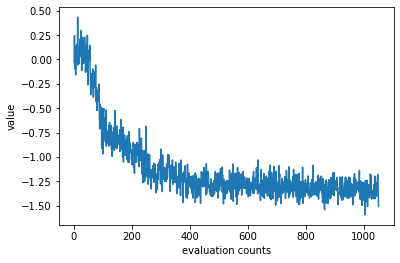

In [45]:
plt.plot(counts, values)
plt.xlabel("evaluation counts")
plt.ylabel("value")

In [46]:
# ED for comparison
ED_state, E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
print(f"ED energy: {E} ;; VQE energy: {result.eigenvalue} ;; diff {E - result.eigenvalue}")
print(f"ED mag: {ED_state.T.conj()@Mag(L,anti)@ED_state} ;; VQE mag: {result.aux_operator_eigenvalues} ;; diff {ED_state.T.conj()@Mag(L,anti)@ED_state - result.aux_operator_eigenvalues}")

ED energy: -4.01850914771919 ;; VQE energy: -1.5080027403019058 ;; diff -2.510506407417284
ED mag: (0.997183282331299+0j) ;; VQE mag: [[-0.1330718941499719]] ;; diff [[(1.130255176481271+0j)]]


As long as this part doesnt work there is no point in simulating / running the anomaly detection with bad states

### Comparison with noiseless simulation

In [47]:
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    
# Hamiltonian
gx = 0.1
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))

# Optimizer and Ansatz
ansatz = qiskit.circuit.library.TwoLocal(L,rotation_blocks='rx', entanglement_blocks='cz', reps=3) #EfficientSU2(L, reps=3) #
#optimizer = SLSQP(maxiter=1000)
#optimizer = COBYLA(maxiter=200)
optimizer = SPSA(maxiter=500)

# Run VQE
t0 = datetime.datetime.now()
vqe = VQE(ansatz=ansatz, optimizer=optimizer, callback=store_intermediate_result, quantum_instance=AerSimulator()) #qi # AerSimulator() for consistency check, with that it works so it really is the noise that is the problem
result = vqe.compute_minimum_eigenvalue(operator=H, aux_operators=[QMag(L,anti)])
print(f"elapsed time {datetime.datetime.now()-t0}")

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


elapsed time 0:01:08.949058


In [50]:
# ED for comparison
ED_state, E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
print(f"ED energy: {E} ;; VQE energy: {result.eigenvalue} ;; diff {E - result.eigenvalue}")
print(f"ED mag: {ED_state.T.conj()@Mag(L,anti)@ED_state} ;; VQE mag: {result.aux_operator_eigenvalues} ;; diff {ED_state.T.conj()@Mag(L,anti)@ED_state - result.aux_operator_eigenvalues}")

ED energy: -4.018509147719188 ;; VQE energy: -3.969144531212165 ;; diff -0.04936461650702295
ED mag: (0.9971832823312707+0j) ;; VQE mag: [[0.9808593750000001]] ;; diff [[(0.01632390733127065+0j)]]


Text(0.5, 1.0, 'Noiseless SImulation')

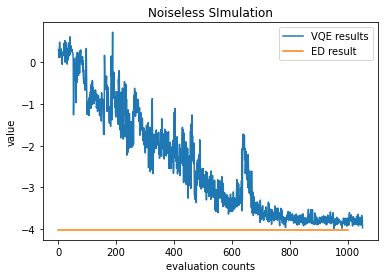

In [52]:
plt.plot(counts, values, label="VQE results")
plt.plot([0,1000],[E]*2, label="ED result")
plt.legend()
plt.xlabel("evaluation counts")
plt.ylabel("value")
plt.title("Noiseless SImulation")

In [38]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [45]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

In [46]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [47]:
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots, seed_simulator=123, seed_transpiler=234) # fix seed to make it reproducible

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
phi = opt_params[0]
run_circuit(thetas, L, num_trash, phi)['11']

<ipython-input-45-a05c1f5c1b9e>:37: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
<ipython-input-45-a05c1f5c1b9e>:43: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = init_vqe(init_state,L=L) + circ
/home/kkottmann/anaconda3/envs/

23

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [49]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=1e-1,
                         #perturbation=0.4
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [50]:
def run_inference(thetas, shots=1000, L=5):
    cost = np.zeros((len(gx_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
            cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
    return cost

## Training on bottom-left

In [52]:
paramss =[
    [0], # train on bottom left point
]

In [54]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")

1 / 1 - params (gz, gx) in [(0, 0.01)]


In [55]:
thetass = [None] * len(paramss)
losss = [None] * len(paramss)
costs = [None] * len(paramss)

## Run 1

1 / 1 - params (gz, gx) in [(0, 0.01)]
Initial cost: 1.069
Time: 26.65872 sec
(array([ 5.32756975, -1.45493624,  3.7899829 ,  6.76658342,  5.1009913 ,
        1.08606106, -0.97363079,  2.74248751,  4.27880354, -2.74954995,
        4.31288663, -1.43048015]), 0.793, 300)


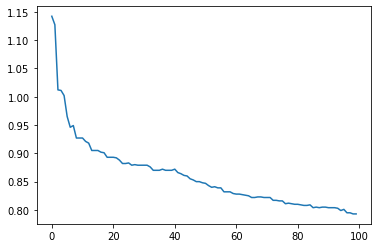

In [56]:
for i,params in enumerate(paramss):
    print(f"{i+1} / {len(paramss)} - params (gz, gx) in {[(gzs[p], gxs[p]) for p in params]}")
    thetas, loss, accepted = optimize(params, max_iter=100, L=5) #, pick_optimizer="adam")
    thetass[i], losss[i] = thetas, loss
    plt.plot(loss)
    cost = run_inference(thetas)
    costs[i] = cost

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$g_x$')

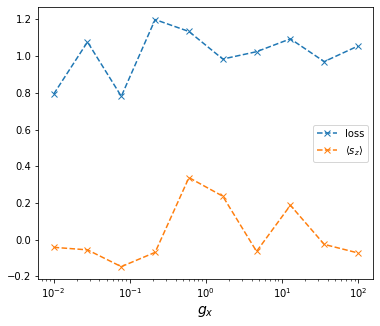

In [65]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))
ax.plot(gxs,cost,"x--", label = "loss")
ax.plot(gxs,Qmags,"x--", label="$\\langle s_z \\rangle$")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("$g_x$", fontsize= 14)